In [ ]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as pyg_utils
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.utils import from_networkx

In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install pandas numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/'
# Load the CSV data
filter_objects_path = path + 'FilterObjects-Average-analysis.csv'
object_relationships_path = path + 'Object relationships.csv'

In [ ]:
filter_df = pd.read_csv(filter_objects_path.replace('/','//'))
relationship_df = pd.read_csv(object_relationships_path.replace('/','//'))

filter_df.head()

,stepNum,ObjectNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,startVol,targetVol,pos,time,radius,dir,ends,strainRate,strainRate_rolling,unknown_cell_type
0,1,1,167,242,195,240,173,229,26.453749,33.721006,...,3.384981,6.416588,"[26.453748502994006, 33.721005988023954]",3.0,0.659283,"[-0.971506178211725, -0.23701423099984514]","[[24.80948344813979, 33.31986163477491], [28.0...",0.000000,0.000000,False
1,1,2,252,352,227,245,195,234,30.326857,34.320571,...,5.066938,7.196064,"[30.32685714285714, 34.32057142857143]",3.0,0.675931,"[-0.9935685020899038, -0.11323264394521951]","[[27.80968192433688, 34.03370001037842], [32.8...",0.000000,0.000000,False
2,2,1,173,276,195,240,172,228,26.323699,33.676023,...,3.384981,6.416588,"[26.323699421965316, 33.67602312138728]",6.0,0.649085,"[-0.9718540475331192, -0.23558376491917635]","[[24.579880811525445, 33.253310107405056], [28...",0.060166,0.030083,False
3,2,2,266,2240,258,269,194,234,30.441383,34.392180,...,5.066938,7.196064,"[30.441383458646616, 34.392180451127814]",6.0,0.960302,"[-0.9638864787737178, -0.2663134544802482]","[[27.38489575031607, 33.54769946907535], [33.4...",0.251645,0.125822,False
4,3,1,182,276,194,240,171,228,26.173978,33.624000,...,3.384981,6.416588,"[26.173978021978016, 33.623999999999995]",9.0,0.656738,"[-0.9655132588965954, -0.2603538878044188]","[[24.3804058525791, 33.1403572503453], [27.967...",0.035286,0.031817,False


In [ ]:
relationship_df.head()

,Module,Module Number,Relationship,First Object Name,First Image Number,First Object Number,Second Object Name,Second Image Number,Second Object Number
0,TrackObjects,7,Parent,FilterObjects,1,1,FilterObjects,2,1
1,TrackObjects,7,Parent,FilterObjects,1,2,FilterObjects,2,2
2,TrackObjects,7,Parent,FilterObjects,2,1,FilterObjects,3,1
3,TrackObjects,7,Parent,FilterObjects,2,2,FilterObjects,3,2
4,TrackObjects,7,Parent,FilterObjects,3,1,FilterObjects,4,1


In [ ]:
# Convert nested list columns to individual tuple columns
filter_df['pos'] = filter_df['pos'].apply(eval).apply(lambda x: tuple(x))
filter_df['dir'] = filter_df['dir'].apply(eval).apply(lambda x: tuple(x))
filter_df[['ends0', 'ends1']] = filter_df['ends'].apply(eval).apply(pd.Series)
filter_df['ends0'] = filter_df['ends0'].apply(lambda x: tuple(x))
filter_df['ends1'] = filter_df['ends1'].apply(lambda x: tuple(x))

In [ ]:
# Select required columns
include_columns = ['stepNum', 'id', 'ObjectNumber', 'parent_id', 'label', 'cellType', 'divideFlag', 'growthRate',
                   'LifeHistory', 'startVol', 'targetVol', 'pos', 'radius', 'length', 'dir',
                   'ends0', 'ends1', 'strainRate', 'strainRate_rolling']
node_features = filter_df[include_columns].copy().query('stepNum<=15')

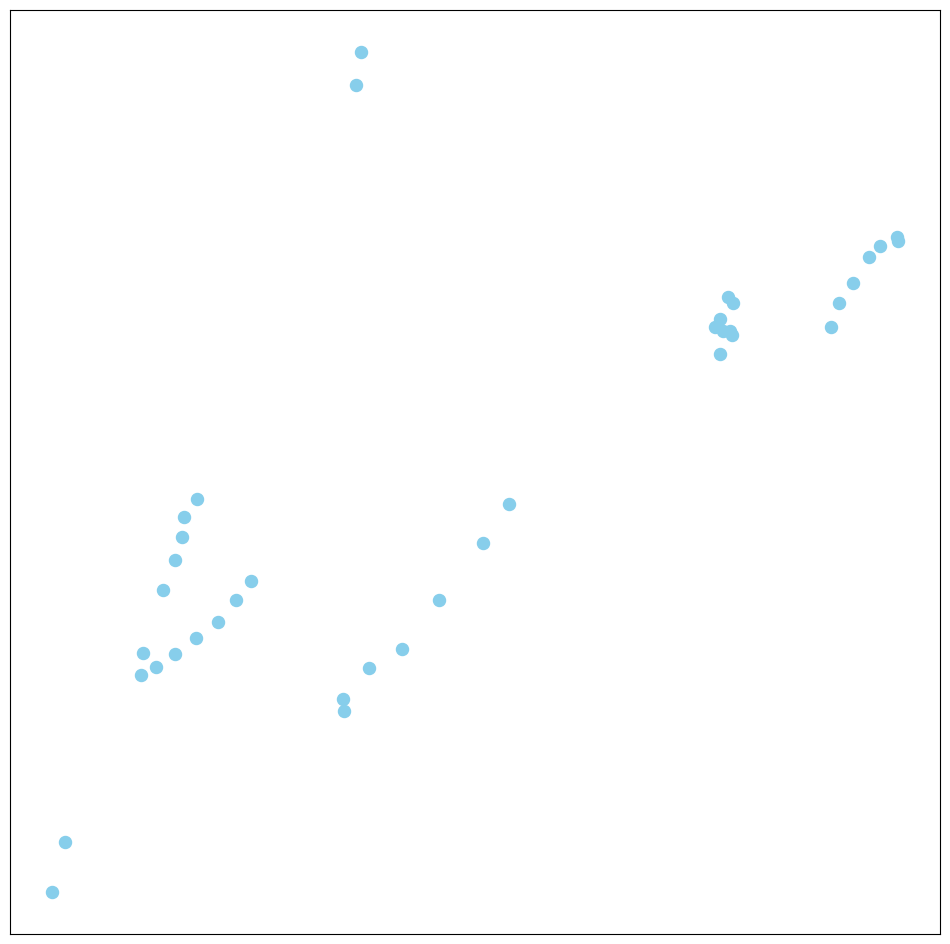

In [ ]:
# Create the graph
G = nx.Graph()

# Add nodes with their features as attributes and label them by their index
for idx, row in node_features.iterrows():
    node_id = idx  # Use the index as a unique label for each node
    G.add_node(node_id, **row.to_dict())

# Define positions for the entire graph
pos = {node: data['pos'] for node, data in G.nodes(data=True)}

# Plot the entire graph
plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=75, node_color='skyblue')


In [ ]:
# Create a unique mapping from (stepNum, ObjectNum) to node index
node_mapping = {(row['stepNum'], row['ObjectNumber']): idx for idx, row in node_features.iterrows()}

# Add edges, considering contact edges
for _, row in relationship_df[relationship_df['First Image Number']<=15].iterrows():
    if row['Relationship'] == 'Neighbors':
      step_num_1 = row['First Image Number']
      step_num_2 = row['Second Image Number']
      node1 = row['First Object Number']
      node2 = row['Second Object Number']

      if (step_num_1, node1) in node_mapping and (step_num_2, node2) in node_mapping:
        if not G.has_edge(node_mapping[(step_num_1, node1)], node_mapping[(step_num_2, node2)]):
          node1_idx = node_mapping[(step_num_1, node1)]
          node2_idx = node_mapping[(step_num_2, node2)]
          G.add_edge(node1_idx, node2_idx)


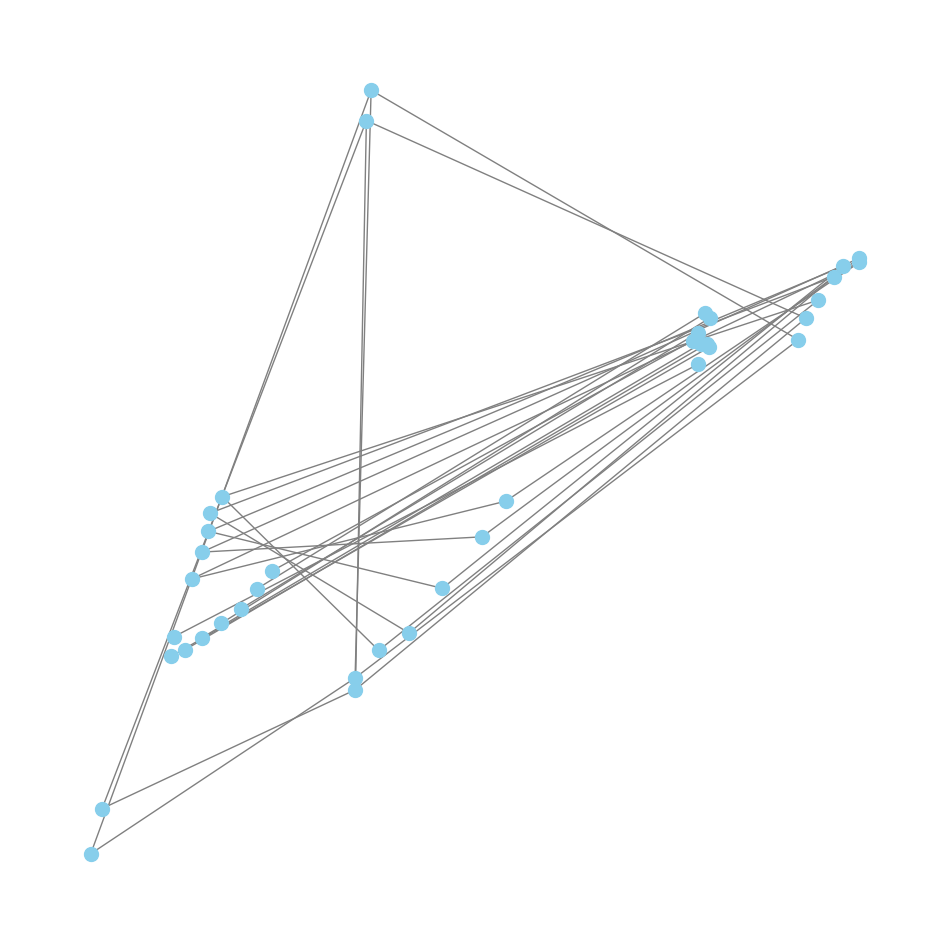

In [ ]:
# Plot the entire graph
plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue')

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray')

plt.axis('off')
plt.show()

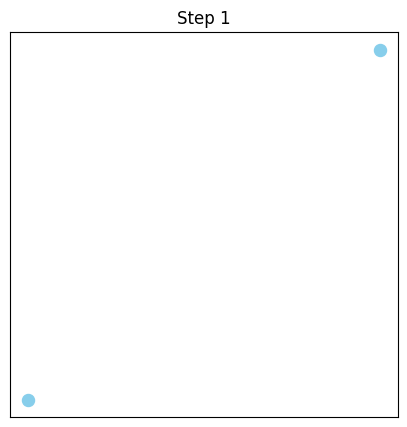

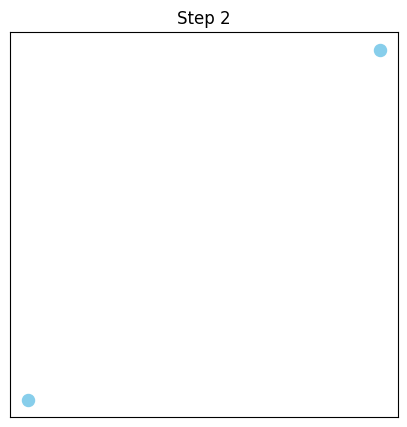

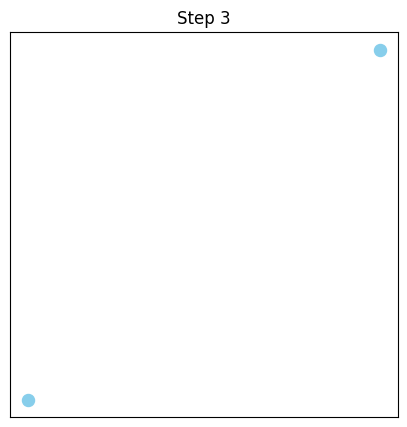

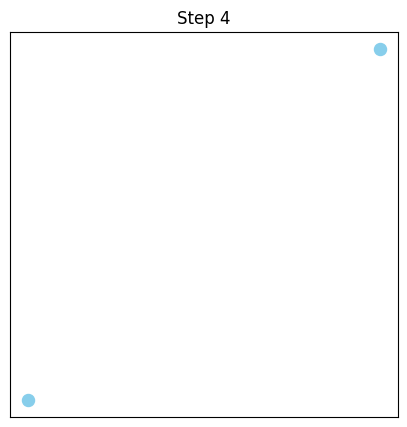

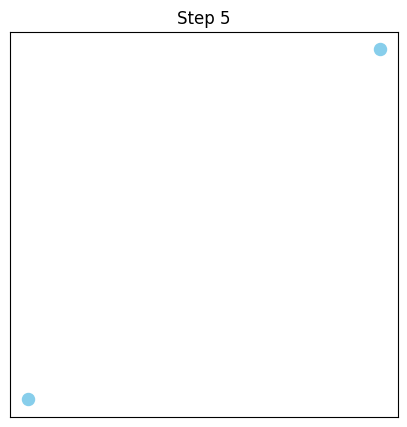

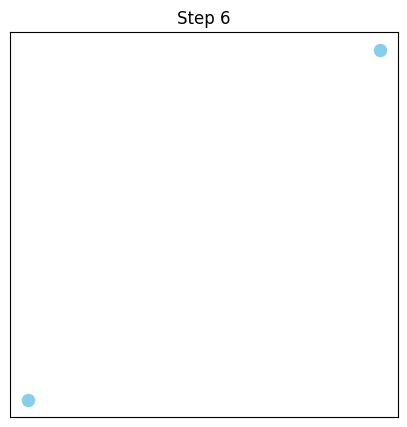

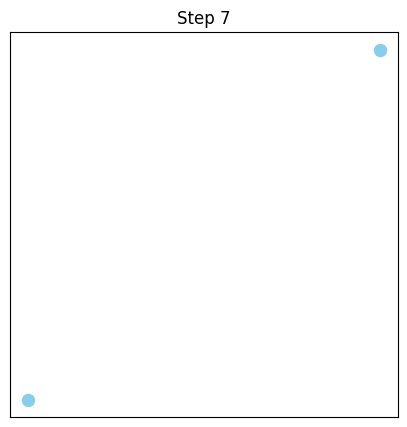

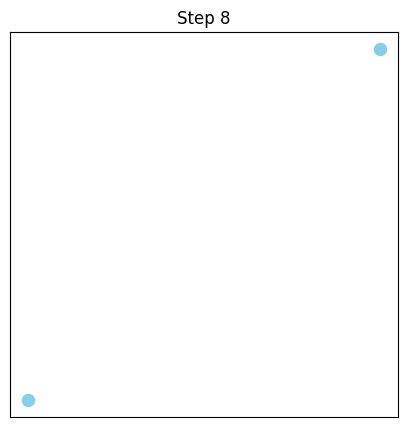

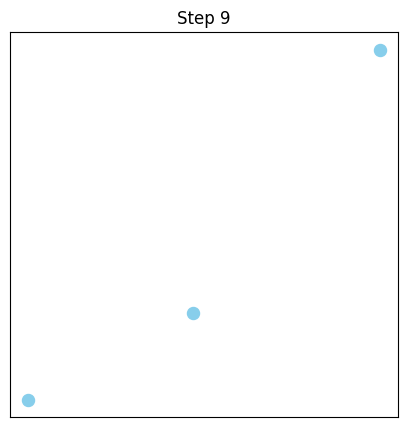

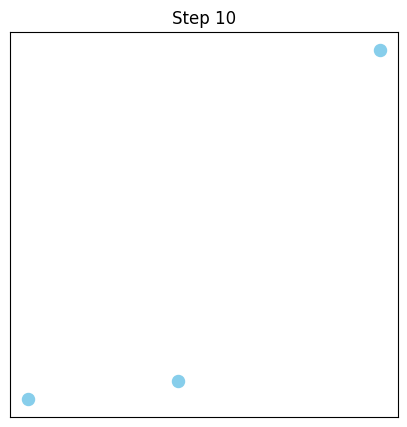

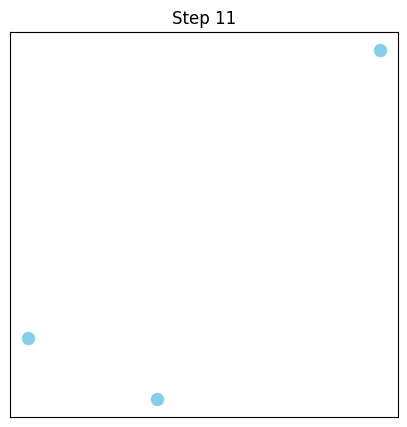

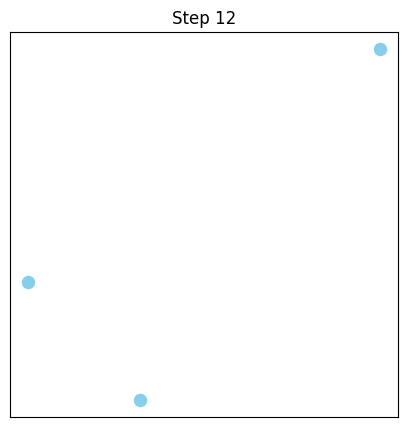

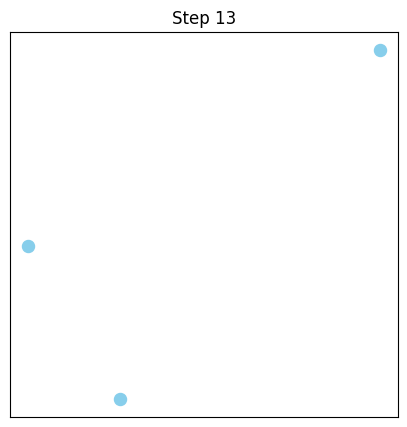

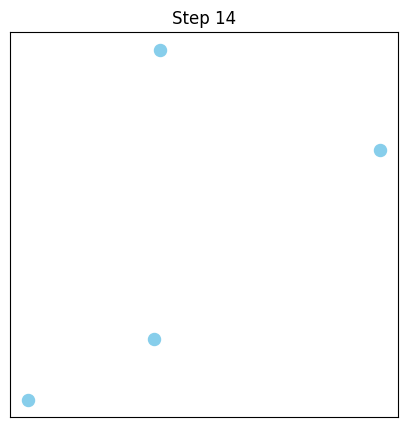

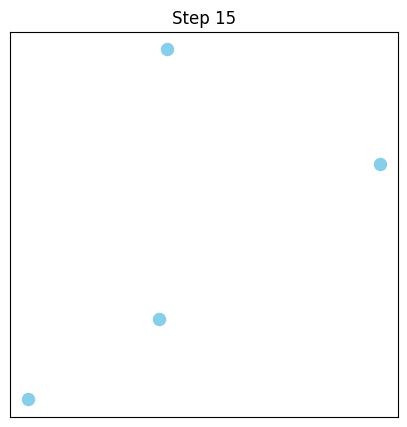

In [ ]:
#Simulating every time step for verification
for i in range(1, 16):

  features = filter_df[filter_df['stepNum']==i]
  # Create the graph
  H = nx.Graph()

  # Add nodes with their features as attributes and label them by their index
  for idx, row in features.iterrows():
      node_id = idx  # Use the index as a unique label for each node
      H.add_node(node_id, **row.to_dict())

  # Define positions for the entire graph
  pos = {node: data['pos'] for node, data in G.nodes(data=True)}

  # Plot the entire graph
  plt.figure(figsize=(5, 5))

  # Draw nodes
  nx.draw_networkx_nodes(H, pos, node_size=75, node_color='skyblue')
  plt.title(f'Step {i}')
  plt.show()

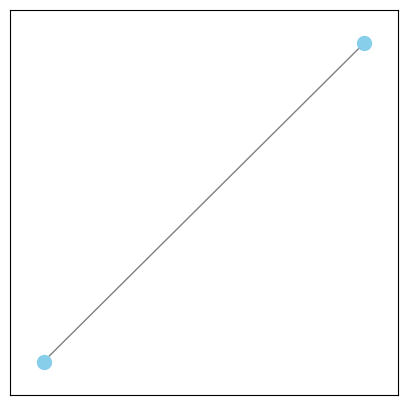

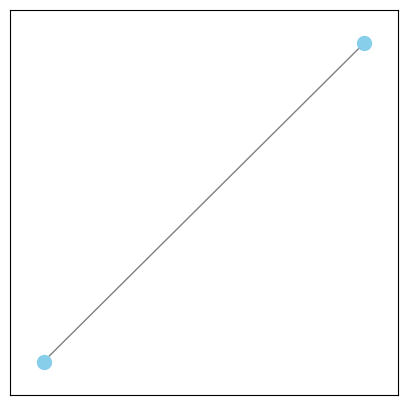

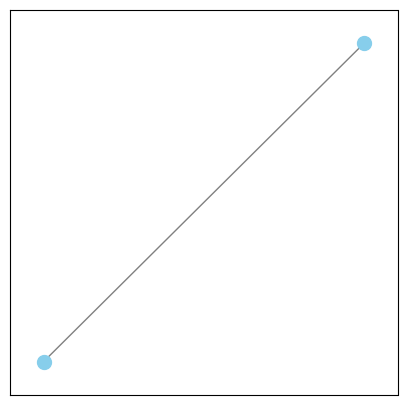

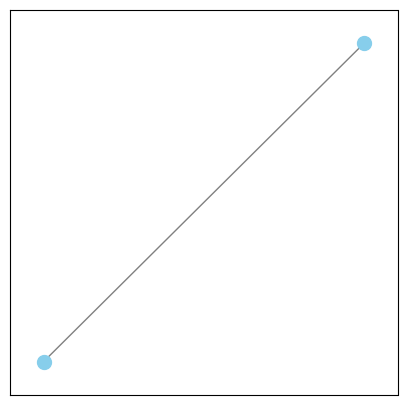

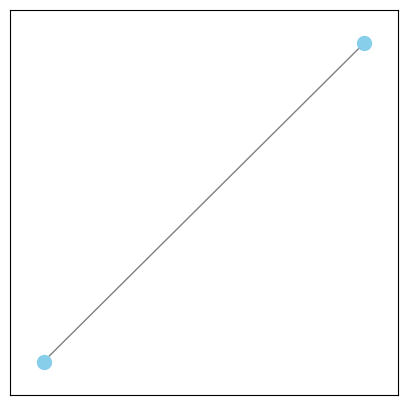

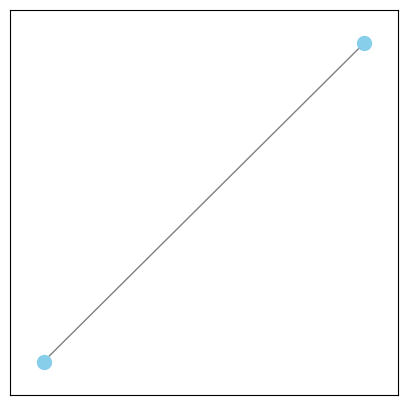

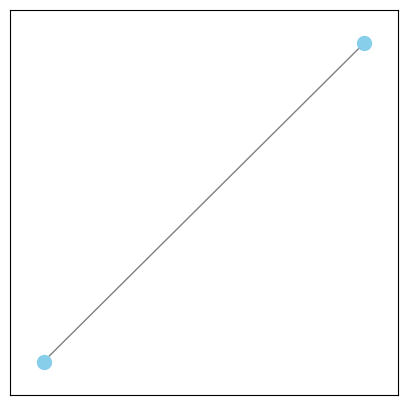

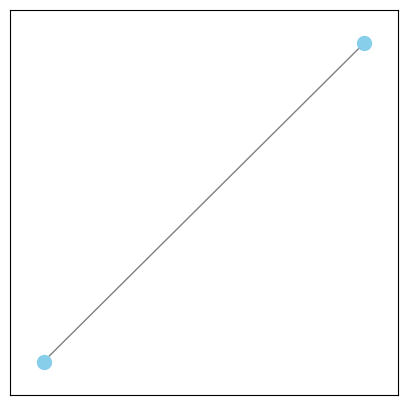

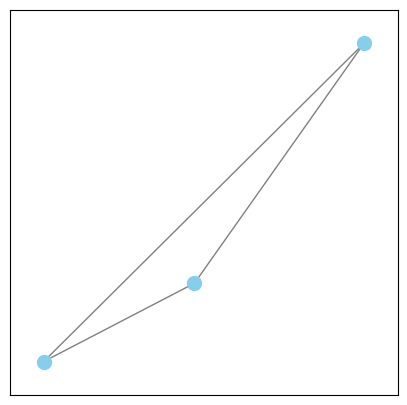

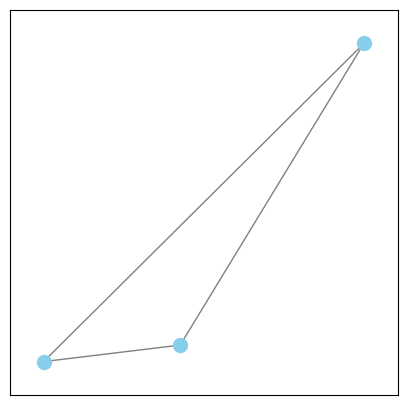

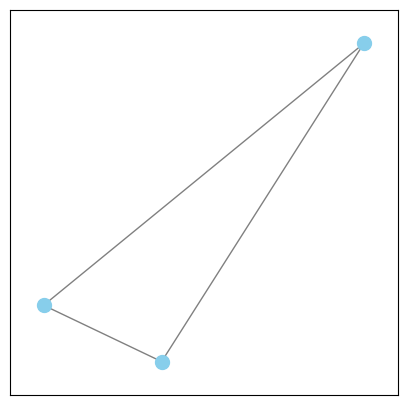

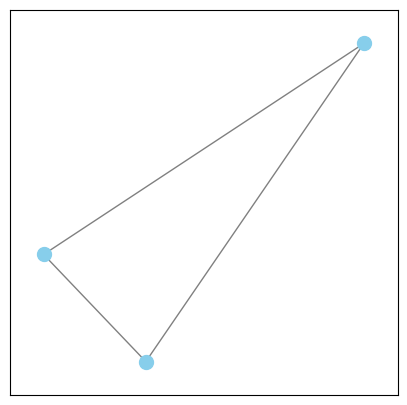

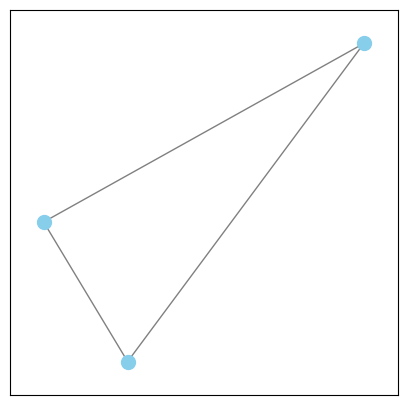

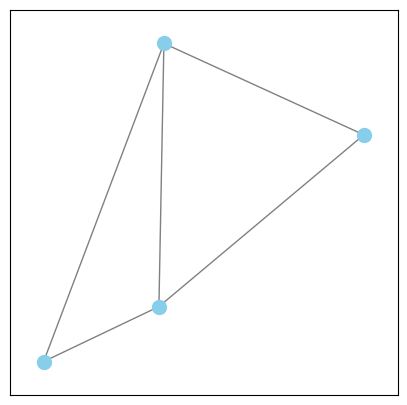

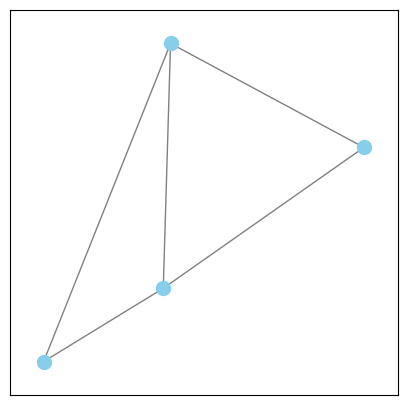

In [ ]:
# make an undirected copy of the digraph
UG = G.to_undirected()

A = list(UG.subgraph(c) for c in nx.connected_components(UG))

for i in A:
  plt.figure(figsize=(5,5))
  pos = {node: data['pos'] for node, data in i.nodes(data=True)}
  nx.draw_networkx_nodes(i, pos, node_size=100, node_color='skyblue')
  nx.draw_networkx_edges(i, pos, edge_color='gray')
  #plt.axis('off')
  plt.show()

Both representations are same, hence proceeding with graph G